In [1]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.tree import export_graphviz
from IPython.display import Image
import os

from rerf.rerfClassifier import rerfClassifier


In [2]:
#读取数据
data = pd.read_excel(r"BreastCancer.xlsx",header=None,engine='openpyxl')
data.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,904971,1,10.94,18.59,70.39,370.0,0.10040,0.07460,0.049440,0.029320,...,12.40,25.58,82.76,472.4,0.1363,0.16440,0.141200,0.07887,0.2251,0.07732
1,9010877,1,13.40,16.95,85.48,552.4,0.07937,0.05696,0.021810,0.014730,...,14.73,21.70,93.76,663.5,0.1213,0.16760,0.136400,0.06987,0.2741,0.07582
2,8911230,1,11.33,14.16,71.79,396.6,0.09379,0.03872,0.001487,0.003333,...,12.20,18.99,77.37,458.0,0.1259,0.07348,0.004955,0.01111,0.2758,0.06386
3,9112085,1,13.38,30.72,86.34,557.2,0.09245,0.07426,0.028190,0.032640,...,15.05,41.61,96.69,705.6,0.1172,0.14210,0.070030,0.07763,0.2196,0.07675
4,89511501,1,12.20,15.21,78.01,457.9,0.08673,0.06545,0.019940,0.016920,...,13.75,21.38,91.11,583.1,0.1256,0.19280,0.116700,0.05556,0.2661,0.07961


In [3]:
data[1]=data[1]-1

In [4]:
data[1].value_counts()

0    357
1    212
Name: 1, dtype: int64

In [5]:
#数据处理

#删除第一列数据
data.pop(0)
#取得并删除标签
labels = np.array(data.pop(1))
data.head()

,2,3,4,5,6,7,8,9,10,11,...,22,23,24,25,26,27,28,29,30,31
0,10.94,18.59,70.39,370.0,0.10040,0.07460,0.049440,0.029320,0.1486,0.06615,...,12.40,25.58,82.76,472.4,0.1363,0.16440,0.141200,0.07887,0.2251,0.07732
1,13.40,16.95,85.48,552.4,0.07937,0.05696,0.021810,0.014730,0.1650,0.05701,...,14.73,21.70,93.76,663.5,0.1213,0.16760,0.136400,0.06987,0.2741,0.07582
2,11.33,14.16,71.79,396.6,0.09379,0.03872,0.001487,0.003333,0.1954,0.05821,...,12.20,18.99,77.37,458.0,0.1259,0.07348,0.004955,0.01111,0.2758,0.06386
3,13.38,30.72,86.34,557.2,0.09245,0.07426,0.028190,0.032640,0.1375,0.06016,...,15.05,41.61,96.69,705.6,0.1172,0.14210,0.070030,0.07763,0.2196,0.07675
4,12.20,15.21,78.01,457.9,0.08673,0.06545,0.019940,0.016920,0.1638,0.06129,...,13.75,21.38,91.11,583.1,0.1256,0.19280,0.116700,0.05556,0.2661,0.07961


In [6]:
# 30%的样本作为测试数据
train, test, train_labels, test_labels = train_test_split(data, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = 0)

In [7]:
train = train.fillna(train.mean())
test = test.fillna(test.mean())

# Features for feature importances特征重要性
features = list(train.columns)

In [19]:
#训练数据
train.shape

(398, 30)

In [20]:
#测试数据
test.shape

(171, 30)

In [10]:
# Create a RerF Classifier
clf = rerfClassifier(n_estimators=100)
# Fit on training data
clf.fit(train, train_labels)

rerfClassifier(n_estimators=100)

In [13]:
# 进行概率预测
train_probs = clf.predict_proba(train)[:, 1]
probs = clf.predict_proba(test)[:, 1]

train_predictions = clf.predict(train)
predictions = clf.predict(test)

In [45]:
from sklearn import metrics
y_pred = clf.predict(test)
print("Accuracy:", metrics.accuracy_score(test_labels, y_pred))

Accuracy: 0.9649122807017544


In [22]:
print(f'训练的 ROC AUC : {roc_auc_score(train_labels, train_probs)}')
print(f'测试的 ROC AUC : {roc_auc_score(test_labels, probs)}')

训练的 ROC AUC : 1.0
测试的 ROC AUC : 0.9939398364485982


In [23]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');


Recall Baseline: 1.0 Test: 0.95 Train: 1.0
Precision Baseline: 0.37 Test: 0.95 Train: 1.0
Roc Baseline: 0.5 Test: 0.99 Train: 1.0


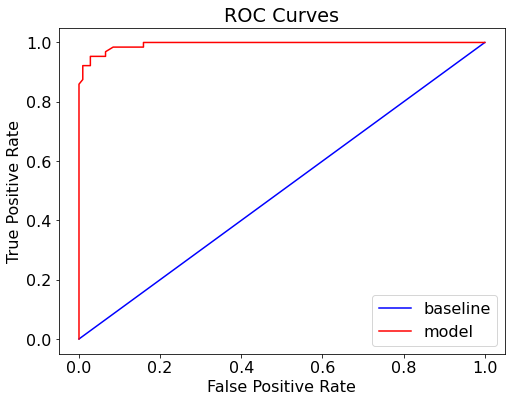

In [25]:
evaluate_model(predictions, probs, train_predictions, train_probs)

In [26]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[104   3]
 [  3  61]]


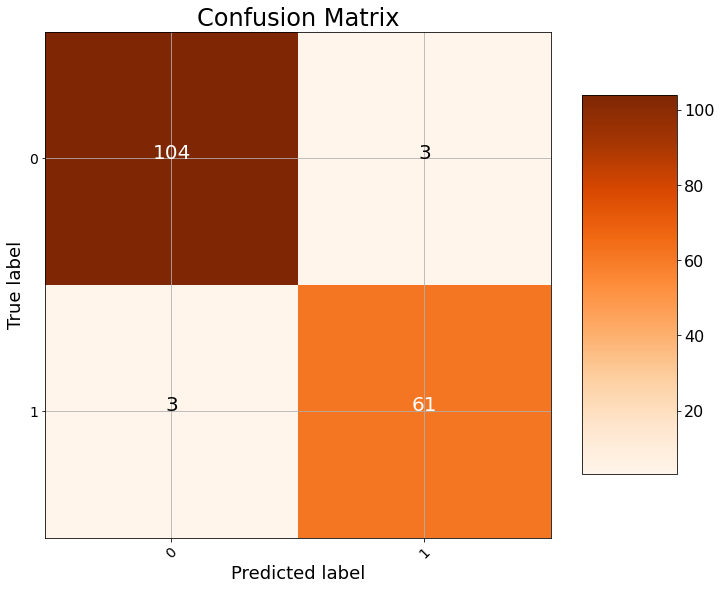

In [27]:
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'Confusion Matrix')

In [38]:
#通过随机搜索优化随机森林
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(1,10,1)),
    'min_samples_split': [2, 5, 10]
}

estimator = rerfClassifier()

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1)

# Fit 
rs.fit(train, train_labels)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/makise/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.99061882        nan        nan 0.98806558 0.98822667        nan
 0.98904139        nan        nan        nan]
  category=UserWarning


RandomizedSearchCV(cv=3, estimator=rerfClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_features': ['auto', 'sqrt', None,
                                                         1, 2, 3, 4, 5, 6, 7, 8,
                                                         9],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([ 10,  13,  17,  21,  25,  29,  33,  37,  41,  44,  48,  52,  56,
        60,  64,  68,  72,  75,  79,  83,  87,  91,  95,  99, 103, 106,
       110, 114, 118, 122, 126, 130, 134, 137, 141, 145, 149, 153, 157,
       161, 165, 168, 172, 176, 180, 184, 188, 

In [39]:
rs.best_params_

{'n_estimators': 165,
 'min_samples_split': 2,
 'max_features': 'auto',
 'max_depth': 4}

In [40]:
best_model = rs.best_estimator_

In [41]:
train_rf_predictions = best_model.predict(train)
train_rf_probs = best_model.predict_proba(train)[:, 1]

rf_predictions = best_model.predict(test)
rf_probs = best_model.predict_proba(test)[:, 1]

In [42]:
# 进行概率预测
predictions = best_model.predict(test)
print(f'训练的 ROC AUC : {roc_auc_score(train_labels, train_rf_probs)}')
print(f'测试的 ROC AUC : {roc_auc_score(test_labels, rf_probs)}')

训练的 ROC AUC : 0.9987567567567568
测试的 ROC AUC : 0.9921144859813084


In [46]:
y_pred = best_model.predict(test)
print("Accuracy:", metrics.accuracy_score(test_labels, y_pred))

Accuracy: 0.9590643274853801
